In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
from sklearn import linear_model
%matplotlib inline

In [2]:
def get_flats(soup):
 divs_html = [i for i in soup.find_all('div', {'class': 'description item_table-description'})]
 flats = [[i.find_all('span', {'class': 'price'}),
           i.find_all('span', {'itemprop': 'name'}),
           i.find_all('span', {'class': 'item-address-georeferences-item__content'})] for i in divs_html]
 flats = [[i, j, k] for i, j, k in flats if i and j and k]
 flats = [[int(flat[0][0].text.replace('\n', '').replace(' ','').replace('₽','')),
           flat[1][0].text.replace('\n', '').strip(),
           flat[2][0].text.replace('\n', '').replace('р-н', '').strip()] for flat in flats]
 return flats

In [3]:
all_flats = []
for i in range(1, 101):
  flats = []
  #if i == 0:
  #  link = 'https://www.avito.ru/perm/kvartiry/prodam'
  #else:
  link = 'https://www.avito.ru/perm/kvartiry/prodam?p={}'.format(i)
  r = requests.get(link)
  soup = BeautifulSoup(r.text, 'lxml')
  flats = get_flats(soup)
  all_flats = all_flats + flats

print('Number of flats: {}'.format(len(all_flats)))
print('Exapmles:')
print(all_flats[0:5])

Number of flats: 5021
Exapmles:
[[3390000, '3-к квартира, 74.7 м², 4/4 эт.', 'Ленинский'], [8500000, '4-к квартира, 131.4 м², 4/5 эт.', 'Свердловский'], [1815450, '1-к квартира, 37.1 м², 5/9 эт.', 'Свердловский'], [2820000, '3-к квартира, 61.3 м², 1/5 эт.', 'Дзержинский'], [1800000, '2-к квартира, 40 м², 4/5 эт.', 'Индустриальный']]


In [4]:
df = pd.DataFrame(all_flats, columns=['price','description','area'])
df.head()

,price,description,area
0,3390000,"3-к квартира, 74.7 м², 4/4 эт.",Ленинский
1,8500000,"4-к квартира, 131.4 м², 4/5 эт.",Свердловский
2,1815450,"1-к квартира, 37.1 м², 5/9 эт.",Свердловский
3,2820000,"3-к квартира, 61.3 м², 1/5 эт.",Дзержинский
4,1800000,"2-к квартира, 40 м², 4/5 эт.",Индустриальный


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 3 columns):
price          5021 non-null int64
description    5021 non-null object
area           5021 non-null object
dtypes: int64(1), object(2)
memory usage: 117.8+ KB


In [6]:
def get_pandas_info(df):
    for column in df.columns:
        print(column)
        values = df[column].unique()
        sorted_values = sorted(values.tolist())
        print('Unique values count: ', len(sorted_values))
        if len(sorted_values) < 20:
            print("Values: "+ str(sorted_values))
        else:
            print("Values: [{}: {}]".format(min(sorted_values), max(sorted_values)))
        inter = set(df[column].unique()) - set(df[column].unique())
        if inter:
            print('Contains nan value')
        print()
        
get_pandas_info(df)  

price
Unique values count:  1111
Values: [130000: 42000000]

description
Unique values count:  3870
Values: [1-к квартира, 12.8 м², 3/5 эт.: Студия, 72.6 м², 12/16 эт.]

area
Unique values count:  8
Values: ['Дзержинский', 'Индустриальный', 'Кировский', 'Ленинский', 'Мотовилихинский', 'Новые Ляды', 'Орджоникидзевский', 'Свердловский']



In [7]:
df.to_csv('flats.csv', sep=';')

In [8]:
df[['room_count', 'square', 'floors']] = pd.DataFrame([ i.split(',') for i in df['description'].tolist()])
df = df.drop(df[(df['room_count'] == 'Своб. планировка') | (df['room_count'] == 'Студия')].index)
df = df.reset_index()
del df['index']
df['floors'] = df['floors'].map(lambda x: ''.join(i for i in x if i.isdigit() or i == '/' or i == '\\'))
df['square'] = df['square'].map(lambda x: ''.join(i for i in x if i.isdigit() or i == '.' ))
df['square'] = df['square'].map(lambda x: ''.join(i for i in x if i != '²'))
df['room_count'] = df['room_count'].map(lambda x: ''.join(i for i in x if i.isdigit()))
df.head()

,price,description,area,room_count,square,floors
0,3390000,"3-к квартира, 74.7 м², 4/4 эт.",Ленинский,3,74.7,4/4
1,8500000,"4-к квартира, 131.4 м², 4/5 эт.",Свердловский,4,131.4,4/5
2,1815450,"1-к квартира, 37.1 м², 5/9 эт.",Свердловский,1,37.1,5/9
3,2820000,"3-к квартира, 61.3 м², 1/5 эт.",Дзержинский,3,61.3,1/5
4,1800000,"2-к квартира, 40 м², 4/5 эт.",Индустриальный,2,40,4/5


In [9]:
df[['floor', 'total_floors']] = pd.DataFrame([i.split('/') for i in df['floors'].tolist()])
numeric_columns = ['price', 'room_count', 'square', 'floor', 'total_floors']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)
del df['description']
del df['floors']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4785 entries, 0 to 4784
Data columns (total 6 columns):
price           4785 non-null int64
area            4785 non-null object
room_count      4785 non-null int64
square          4785 non-null float64
floor           4785 non-null int64
total_floors    4785 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 224.4+ KB


In [10]:
get_pandas_info(df) 

price
Unique values count:  1059
Values: [200000: 42000000]

area
Unique values count:  8
Values: ['Дзержинский', 'Индустриальный', 'Кировский', 'Ленинский', 'Мотовилихинский', 'Новые Ляды', 'Орджоникидзевский', 'Свердловский']

room_count
Unique values count:  6
Values: [1, 2, 3, 4, 5, 6]

square
Unique values count:  775
Values: [12.8: 593.0]

floor
Unique values count:  25
Values: [1: 25]

total_floors
Unique values count:  28
Values: [1: 32]



In [11]:
df.head()

,price,area,room_count,square,floor,total_floors
0,3390000,Ленинский,3,74.7,4,4
1,8500000,Свердловский,4,131.4,4,5
2,1815450,Свердловский,1,37.1,5,9
3,2820000,Дзержинский,3,61.3,1,5
4,1800000,Индустриальный,2,40.0,4,5


In [12]:
df.describe()

,price,room_count,square,floor,total_floors
count,4.785000e+03,4785.000000,4785.000000,4785.000000,4785.000000
mean,3.200996e+06,2.114943,55.822738,5.601672,10.455799
std,2.033395e+06,0.923810,26.509185,4.646959,6.409991
min,2.000000e+05,1.000000,12.800000,1.000000,1.000000
25%,2.090000e+06,1.000000,40.000000,2.000000,5.000000
50%,2.700000e+06,2.000000,49.900000,4.000000,9.000000
75%,3.600000e+06,3.000000,64.300000,8.000000,16.000000
max,4.200000e+07,6.000000,593.000000,25.000000,32.000000


In [13]:
df = df.drop(df[(df['price'] > 10000000) | (df['price'] < 500000)].index)
df = df.reset_index()
del df['index']
df = df.drop(df[(df['square'] > 300)].index)
df = df.reset_index()
del df['index']

In [14]:
df.describe()

,price,room_count,square,floor,total_floors
count,4.717000e+03,4717.000000,4717.000000,4717.000000,4717.000000
mean,3.056357e+06,2.089464,54.301208,5.562434,10.427814
std,1.492325e+06,0.897675,21.721350,4.604706,6.390738
min,5.200000e+05,1.000000,12.800000,1.000000,1.000000
25%,2.080000e+06,1.000000,40.000000,2.000000,5.000000
50%,2.700000e+06,2.000000,49.000000,4.000000,9.000000
75%,3.555000e+06,3.000000,63.300000,8.000000,16.000000
max,1.000000e+07,6.000000,187.000000,25.000000,32.000000


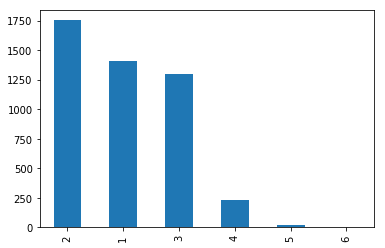

In [15]:
df['room_count'].value_counts().plot(kind='bar')

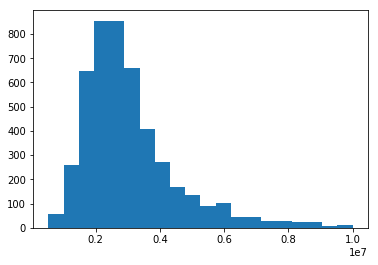

In [16]:
plt.hist(df['price'], bins=20)
plt.show()

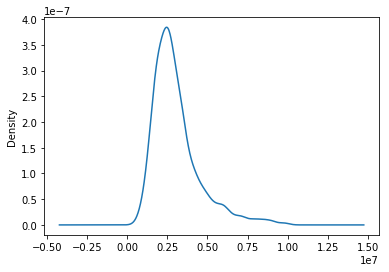

In [17]:
df['price'].plot.kde()

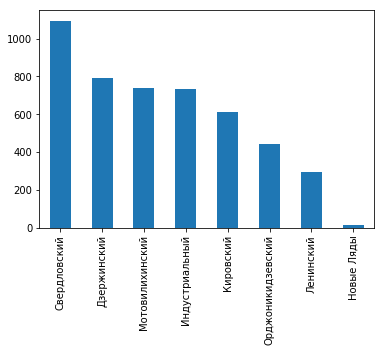

In [18]:
df['area'].value_counts().plot(kind='bar')

In [20]:
df = df.drop(df[(df['area'] == 'Новые Ляды')].index)
df = df.reset_index()
del df['index']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4705 entries, 0 to 4704
Data columns (total 6 columns):
price           4705 non-null int64
area            4705 non-null object
room_count      4705 non-null int64
square          4705 non-null float64
floor           4705 non-null int64
total_floors    4705 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 220.6+ KB


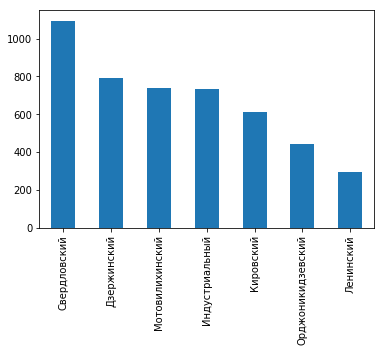

In [22]:
df['area'].value_counts().plot(kind='bar')

C:\Users\HP\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


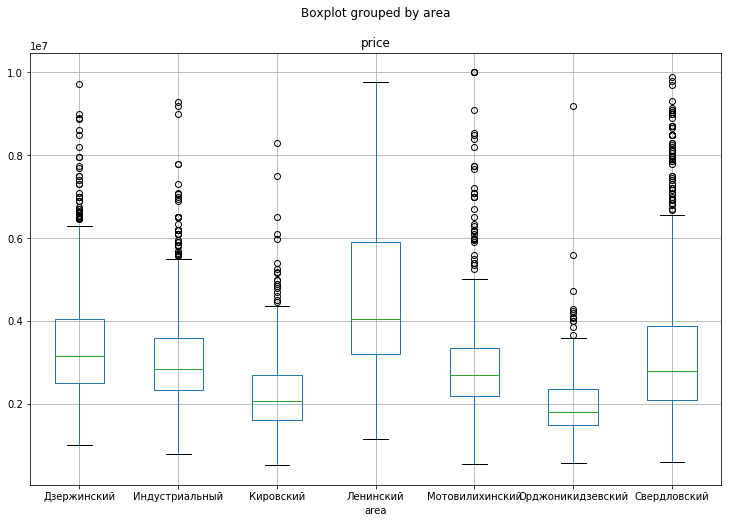

In [23]:
df.boxplot(column='price',  by='area', figsize=(12,8))
plt.show()

C:\Users\HP\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


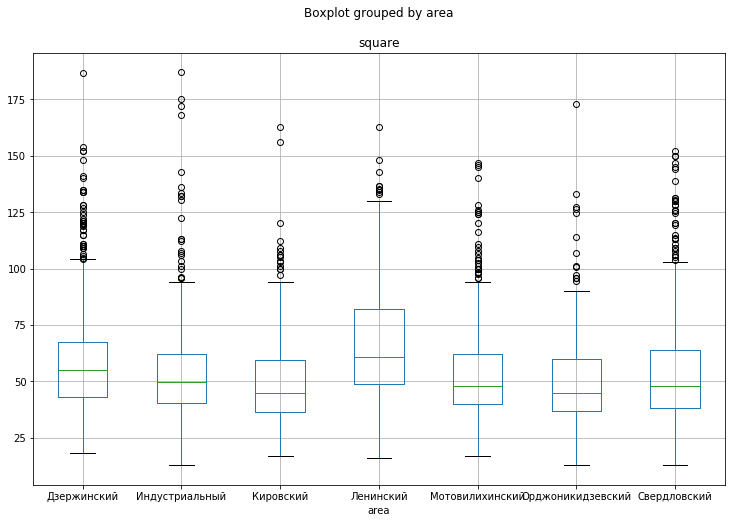

In [24]:
df.boxplot(column='square',  by='area', figsize=(12,8))
plt.show()

In [166]:
df.describe()

,price,room_count,square,floor,total_floors
count,4.710000e+03,4710.000000,4710.000000,4710.000000,4710.000000
mean,3.060140e+06,2.087261,54.297558,5.558386,10.427176
std,1.495453e+06,0.896317,21.785558,4.582215,6.382388
min,5.200000e+05,1.000000,12.800000,1.000000,1.000000
25%,2.090000e+06,1.000000,40.000000,2.000000,5.000000
50%,2.700000e+06,2.000000,49.000000,4.000000,9.000000
75%,3.558889e+06,3.000000,63.300000,8.000000,16.000000
max,1.000000e+07,6.000000,187.000000,25.000000,32.000000


In [25]:
df['area'] = df['area'].map({'Дзержинский': 1, 'Индустриальный': 2, 'Кировский': 3, 'Ленинский': 4, 'Мотовилихинский': 5, 'Орджоникидзевский': 6, 'Свердловский': 7})

In [26]:
dfDummies = pd.get_dummies(df['area'], prefix = 'area')
dfDummies.head()

,area_1,area_2,area_3,area_4,area_5,area_6,area_7
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0


In [27]:
df = pd.concat([df, dfDummies], axis=1)
df.head()

,price,area,room_count,square,floor,total_floors,area_1,area_2,area_3,area_4,area_5,area_6,area_7
0,3390000,4,3,74.7,4,4,0,0,0,1,0,0,0
1,8500000,7,4,131.4,4,5,0,0,0,0,0,0,1
2,1815450,7,1,37.1,5,9,0,0,0,0,0,0,1
3,2820000,1,3,61.3,1,5,1,0,0,0,0,0,0
4,1800000,2,2,40.0,4,5,0,1,0,0,0,0,0


In [28]:
df['price'] = np.log10(df['price'] + 1)
cls = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=4)

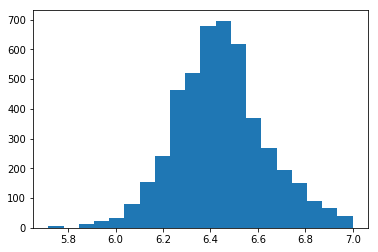

In [29]:
plt.hist(df['price'], bins=20)
plt.show()

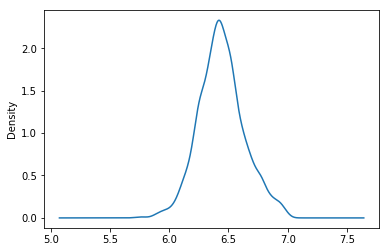

In [30]:
df['price'].plot.kde()

In [31]:
X_train, X_test, y_train, y_test = train_test_split( df[list(set(df.columns)-set(['price', 'area']))], df['price'], test_size=0.2, random_state=42)

In [32]:
cls.fit(X_train, y_train)
score = cls.score(X_train, y_train)
print(score)

0.786812866215


In [33]:
features = list(set(df.columns)-set(['price', 'area']))
importances = cls.feature_importances_
indices = np.argsort(importances)

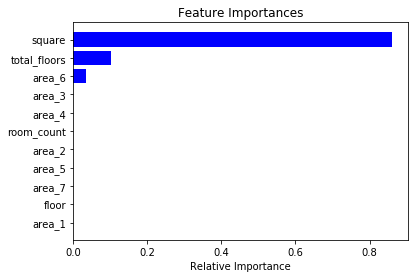

In [34]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error as mse
cnt_predict = cls.predict(X_test[features][:])
mse(y_test, cnt_predict)

0.0080051343782585778

In [36]:
test_r2 = r2_score(y_test, cls.predict(X_test[features][:]))
test_r2

0.79471301141011974

In [37]:
test_r2 = r2_score(y_test, cls.predict(X_test[features][:]))
test_r2

0.79471301141011974

In [38]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': cnt_predict})

df_res = df_res.head(25)

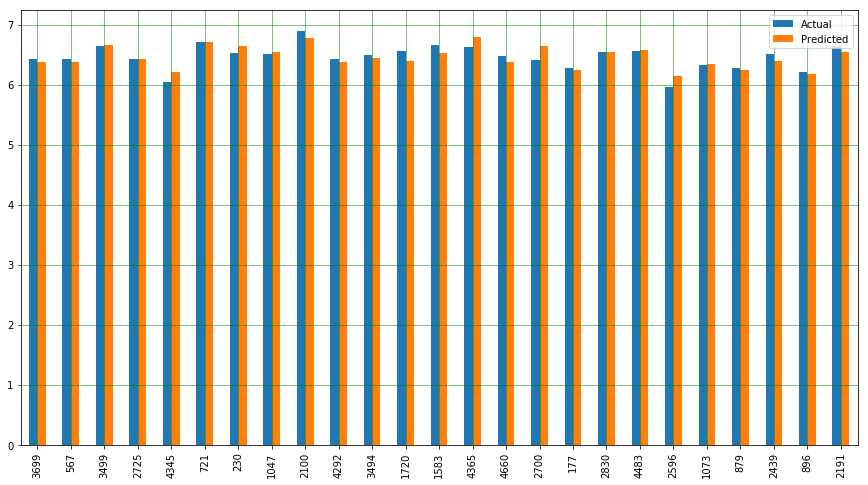

In [39]:
df_res.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [40]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.coef_

array([ 0.01878725,  0.00557975,  0.00157462,  0.03586848, -0.07553844,
        0.1131948 ,  0.01705068, -0.11961575,  0.00761426,  0.01025299,
        0.01236713])

In [41]:
# Точность на обучающей выборке.
train_r2 = r2_score(y_train, reg.predict(X_train))
train_r2

0.79732266024955378

In [42]:
test_r2 = r2_score(y_test, reg.predict(X_test))
test_r2

0.82221006120956142

In [43]:
features = list(set(df.columns)-set(['price', 'area']))
importances = reg.coef_
indices = np.argsort(importances)

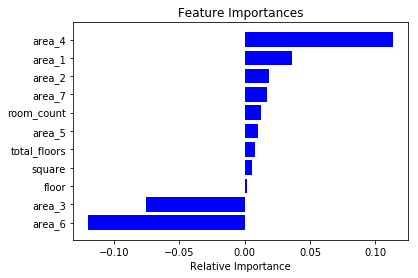

In [44]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [45]:
X_train.head()

,area_2,square,floor,area_1,area_3,area_4,area_7,area_6,total_floors,area_5,room_count
3024,0,44.3,2,0,0,0,1,0,5,0,2
2233,0,83.2,11,0,0,0,1,0,26,0,3
426,0,32.0,3,0,0,0,1,0,3,0,1
3825,0,30.0,3,1,0,0,0,0,4,0,1
605,1,48.5,14,0,0,0,0,0,23,0,2


In [46]:
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': reg.predict(X_test)})
df_res = df_res.head(25)

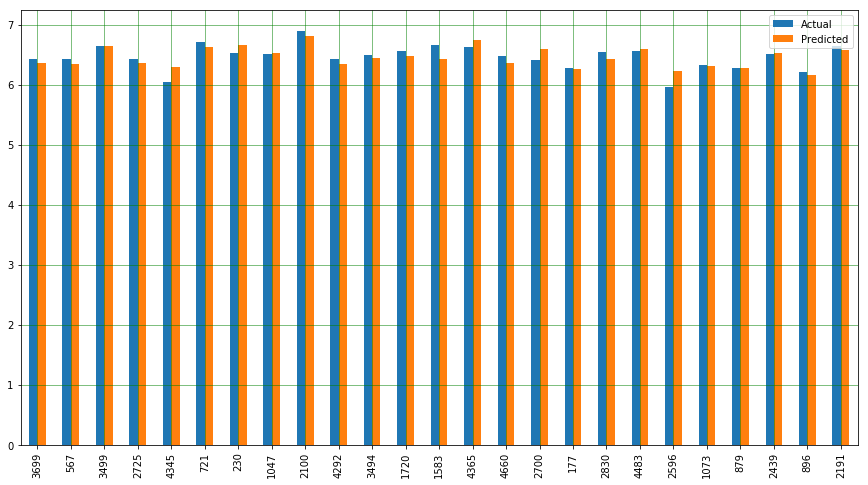

In [47]:
df_res.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [48]:
X_train.head()

,area_2,square,floor,area_1,area_3,area_4,area_7,area_6,total_floors,area_5,room_count
3024,0,44.3,2,0,0,0,1,0,5,0,2
2233,0,83.2,11,0,0,0,1,0,26,0,3
426,0,32.0,3,0,0,0,1,0,3,0,1
3825,0,30.0,3,1,0,0,0,0,4,0,1
605,1,48.5,14,0,0,0,0,0,23,0,2


In [50]:
y_train.head()

3024    6.374749
2233    6.919078
426     6.130334
3825    6.243038
605     6.474899
Name: price, dtype: float64